<a href="https://colab.research.google.com/github/cerezamo/dl_ensae2020/blob/master/TEST_USPS_MNIST_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning - ENSAE 2020** 

In this notebook we undertake an Image-to-Image translation using the Cycle-GANs architecture. The first section uses a simple architecture proposed in the Cycle-GAN introductory [paper](https://arxiv.org/pdf/1703.10593.pdf) and its Pytorch implementation in the following [github](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix). The task is to translate from USPS to MNIST. Section 2 proposes improvements based on [(Martin Arjovsky et al., 2017)]() and computes a Wasserstein Cycle-GAN on the same task. Regarding the good results achieved with those two first methods, Section 3 increases (a lot) the tasks difficulty and tries to translate from two different collections of satellite imagery of the city of Alep in Syria.  

## **Cycle-Gans application** : from MNIST to USPS 

### Import packages 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.utils as utils
import torch.nn.functional as F
import torch.utils as tutils
from torchvision import datasets
from torchvision import transforms
import numpy as np
from torchvision import datasets, models, transforms
import os 

This code is adapted from [yunjey](https://github.com/yunjey/) ,[yunjey](https://github.com/yunjey/mnist-svhn-transfer/blob/master/model.py) and the assignment proposed. 

### Download and construct loaders for USPS and Mnist

In [0]:
def get_loader_mnist(image_size,batch_size):
  transform = transforms.Compose([
                    transforms.CenterCrop(22),
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])
  
  mnist_train = datasets.MNIST(root='content/',download=True, transform = transform,train=True)
  mnist_test = datasets.MNIST(root='content/',download=True, transform = transform,train=False)

  train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                             batch_size=batch_size,
                                             shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                             batch_size=batch_size,
                                             shuffle=False)
  
  return train_loader, test_loader 

In [0]:
def get_loader_usps(image_size,batch_size):
  transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])
  
  usps_train = datasets.USPS(root='content/',download=True, transform = transform,train=True)
  usps_test = datasets.USPS(root='content/',download=True, transform = transform,train=False)

  train_loader = torch.utils.data.DataLoader(dataset=usps_train,
                                             batch_size=batch_size,
                                             shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(dataset=usps_test,
                                             batch_size=batch_size,
                                             shuffle=False)
  
  return train_loader, test_loader 

In [0]:
M_train_loader, M_test_loader =get_loader_mnist(image_size,batch_size)

Extracting content/MNIST/raw/train-images-idx3-ubyte.gz to content/MNIST/raw


Extracting content/MNIST/raw/train-labels-idx1-ubyte.gz to content/MNIST/raw



Extracting content/MNIST/raw/t10k-images-idx3-ubyte.gz to content/MNIST/raw


Extracting content/MNIST/raw/t10k-labels-idx1-ubyte.gz to content/MNIST/raw
Processing...
Done!


In [0]:
U_train_loader, U_test_loader =get_loader_usps(image_size,batch_size)

In [0]:
examples_mnist = enumerate(M_train_loader)
batch_idx, (example_data_mnist, example_targets_mnist) = next(examples_mnist)

examples_usps = enumerate(U_train_loader)
batch_idx, (example_data_usps, example_targets_usps) = next(examples_usps)

In [0]:
example_data_usps.shape, example_data_mnist.shape # 64 per batch, size 32x32  # 64 per batch, size 32x32 

(torch.Size([64, 1, 32, 32]), torch.Size([64, 1, 32, 32]))

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
  for i in range(len(example_targets_mnist)):
    if example_targets_mnist[i].item() in list_label:
      pass
    else:
      list_label.append(example_targets_mnist[i].item())
      list_images.append(example_data_mnist[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

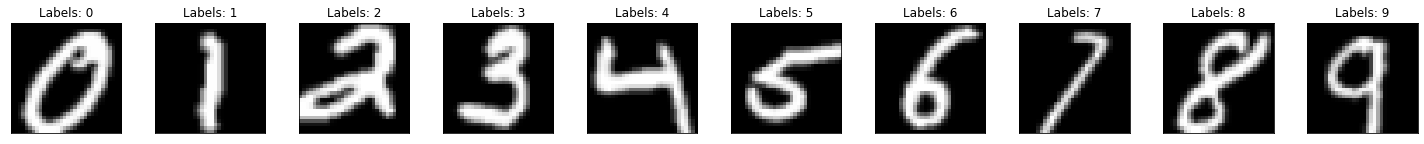

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,12))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
  plt.title("Labels: {}".format(list_label[i]))
  plt.xticks([])
  plt.yticks([])

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
  for i in range(len(example_targets_usps)):
    if example_targets_usps[i].item() in list_label:
      pass
    else:
      list_label.append(example_targets_usps[i].item())
      list_images.append(example_data_usps[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

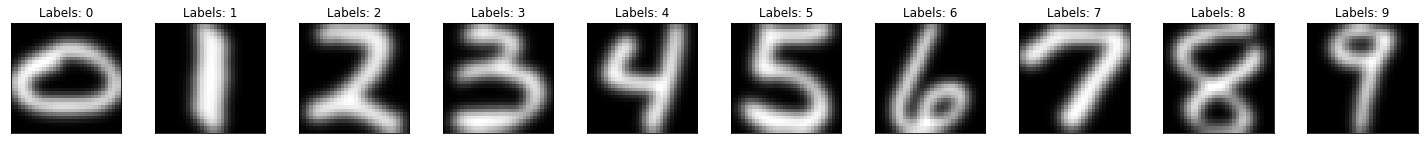

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,12))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
  plt.title("Labels: {}".format(list_label[i]))
  plt.xticks([])
  plt.yticks([])

In [0]:
example_data_mnist.size()

torch.Size([64, 1, 32, 32])

The USPS dataset consists of 7,291 training images and 2007 test images each of which is of the original size of 16x16. The MNIST dataset consists of 60 000 training images and 10 000 test images each of which is of the size 28x28. Both contains 10 categories (numbers from 0 to 9) and follow distinct distributions. 

#### Helper functions

In [0]:
import torch.nn as nn

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom deconvolutional layer """
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom convolutional layer"""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

# Batch norm True False (last layer)

Construction of the two discriminators 

In [0]:
class D_MNIST(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D_MNIST, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

class D_USPS(nn.Module):
    """Discriminator for usps."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D_USPS, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False) #1
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out


Creating the two generators 

In [0]:
class G_MNIST_USPS(nn.Module):
    """Generator for transfering from mnist to usps"""
    def __init__(self, conv_dim=64):
        super(G_MNIST_USPS, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out

class G_USPS_MNIST(nn.Module):
    """Generator for transfering from usps to mnist"""
    def __init__(self, conv_dim=64):
        super(G_USPS_MNIST, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out


Building model 

In [0]:
def print_models(G_MtoU, G_UtoM, D_M, D_U):
    """Prints model information for the generators and discriminators.
    """
    print("                 G_MtoU                ")
    print("---------------------------------------")
    print(G_MtoU)
    print("---------------------------------------")

    print("                 G_UtoM                ")
    print("---------------------------------------")
    print(G_UtoM)
    print("---------------------------------------")

    print("                  D_M                  ")
    print("---------------------------------------")
    print(D_M)
    print("---------------------------------------")

    print("                  D_U                  ")
    print("---------------------------------------")
    print(D_U)
    print("---------------------------------------")

In [0]:
def create_model():
  G_MtoU = G_MNIST_USPS()
  G_UtoM = G_USPS_MNIST()
  D_M = D_MNIST()
  D_U = D_USPS()

  print_models(G_MtoU, G_UtoM, D_M, D_U)

  if torch.cuda.is_available():
      G_MtoU.cuda()
      G_UtoM.cuda()
      D_M.cuda()
      D_U.cuda()
      print('Models moved to GPU.')
  return G_MtoU,G_UtoM, D_M, D_U

In [0]:
def save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU):
    """Saves samples from both generators M->U and U->M.
    """
    import os
    import imageio
    fake_M = G_UtoM(fixed_U)
    fake_U = G_MtoU(fixed_M)

    M, fake_M = to_data(fixed_M), to_data(fake_M)
    U, fake_U = to_data(fixed_U), to_data(fake_U)

    merged = merge_images(M, fake_U)
    path = os.path.join('/content/', 'sample-{:06d}-M-U.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(U, fake_M)
    path = os.path.join('/content/', 'sample-{:06d}-U-M.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [0]:
def merge_images(sources, targets, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2]) # 3
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)

Helper functions 

In [0]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

### Training loop

In [0]:
# Check number of parameters in the generator
pytorch_total_params = sum(p.numel() for p in G_MNIST_USPS().parameters())
pytorch_total_params

560128

In [0]:
[torch.std(p).item() for p in G_MNIST_USPS().parameters()]

[0.14411965012550354,
 0.0,
 0.0,
 0.018012182787060738,
 0.0,
 0.0,
 0.017013899981975555,
 0.0,
 0.0,
 0.017013514414429665,
 0.0,
 0.0,
 0.018053261563181877,
 0.0,
 0.0,
 0.14460092782974243]

In [0]:
G_MtoU, G_UtoM, D_M, D_U = create_model()

iter_M = iter(M_train_loader)
iter_U = iter(U_train_loader)


                 G_MtoU                
---------------------------------------
G_MNIST_USPS(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

In [0]:
images_M, labels_M = iter_M.next()
images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

In [0]:
# Compute the discriminator losses on real images
out_M = D_M(images_M) # discriminator mnist true
#D_M_loss = torch.mean((out_M-1)**2) 

In [0]:
out_M

tensor([ 0.2239,  0.2320,  0.0634,  0.0598,  0.2448,  0.0676,  0.4505,  0.5053,
        -0.2431, -0.0935,  0.6951,  0.7418,  0.5591,  0.1627,  0.4361,  0.1604,
         0.2521,  0.3427,  0.0935,  0.3805,  0.4336,  1.0922,  0.5143,  0.0138,
         0.5848, -0.0446,  0.2944,  0.4483, -0.1428, -0.1015,  0.2153, -0.0944,
         0.4546,  0.3822,  0.4425, -0.1694,  0.1318,  0.0861,  0.0304,  0.0427,
         0.3522,  0.2573,  0.4582,  0.2563,  0.1378,  0.5268,  0.3860, -0.2368,
         0.3703,  0.3108,  0.4408,  0.6655,  0.0784,  0.1322,  0.1849, -0.3596,
         0.3978,  0.4776,  0.3512, -0.1268,  0.3235,  0.4257,  0.3164,  0.2606],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [0]:
torch.mean((out_M-1)**2).item(), torch.mean(out_M-1).item()


(0.6238396763801575, -0.7447456121444702)

In [0]:
def training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=20000, log_step = 10, batch_size=64, use_cycle_consistency_loss=True):
  # Create generators and discriminators
  G_MtoU, G_UtoM, D_M, D_U = create_model()

  g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())  # Get generator parameters
  d_params = list(D_M.parameters()) + list(D_U.parameters())  # Get discriminator parameters

  # Create optimizers for the generators and discriminators
  g_optimizer = optim.Adam(g_params, lr)
  d_optimizer = optim.Adam(d_params, lr)

  iter_M = iter(M_train_loader)
  iter_U = iter(U_train_loader)

  test_iter_M = iter(M_test_loader)
  test_iter_U = iter(U_test_loader)

  # Get some fixed data from domains X and Y for sampling. These are images that are held
  # constant throughout training, that allow us to inspect the model's performance.
  fixed_M = to_var(test_iter_M.next()[0])
  fixed_U = to_var(test_iter_U.next()[0])

  iter_per_epoch = min(len(iter_M), len(iter_U))

  for iteration in range(1, train_iters+1):

      # Reset data_iter for each epoch
      if iteration % iter_per_epoch == 0:
          iter_M = iter(M_train_loader)
          iter_U = iter(U_train_loader)

      images_M, labels_M = iter_M.next()
      images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

      images_U, labels_U = iter_U.next()
      images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()

     # num_classes = 10

      #if use_labels:
      #  M_fake_labels = to_var(
       #     torch.Tensor([num_classes]*images_U.size(0)).long())
        #svhn_fake_labels = to_var(
         #   torch.Tensor([num_classes]*images_M.size(0)).long())


      # ============================================
      #            TRAIN THE DISCRIMINATORS
      # ============================================

       # Clipping discriminator parameters 
      for p in D_M.parameters():
            p.data.clamp_(-0.01, 0.01)

      # Train with real images
      d_optimizer.zero_grad()

      # Compute the discriminator losses on real images
      out_M = D_M(images_M) # discriminator mnist true
      D_M_loss = torch.mean((out_M-1)**2) 

      out_U = D_U(images_U)
      D_U_loss = torch.mean((out_U-1)**2)

      d_real_loss = D_M_loss + D_U_loss
      d_real_loss.backward()
      d_optimizer.step()

      # Train with fake images
      d_optimizer.zero_grad()

      # Generate fake images that look like domain MNIST based on real images in domain USPS
      fake_M = G_UtoM(images_U)

      # Compute the loss for D_M
      out_M = D_M(fake_M)
      D_M_loss = torch.mean(out_M**2) 

      # 4. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_MtoU(images_M)

      # 5. Compute the loss for D_U
      out_U = D_U(fake_U)
      D_U_loss = torch.mean((out_U)**2) 

      d_fake_loss = D_M_loss + D_U_loss
      d_fake_loss.backward()
      d_optimizer.step()

      # =========================================
      #            TRAIN THE GENERATORS
      # =========================================

      ## U--M-->U 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain M based on real images in domain U
      fake_M = G_UtoM(images_U)
      out = D_M(fake_M)

      # 2. Compute the generator loss based on domain M

      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_U = G_MtoU(fake_M)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()

      ## M--U-->M 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_MtoU(images_M)
      out = D_U(fake_U)

      # 2. Compute the generator loss based on domain U
      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_M = G_UtoM(fake_U)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()


      # Print the log info
      if iteration % log_step == 0:
          print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                  D_M_loss.item(), d_fake_loss.item(), g_loss.item()))


      # Save the generated samples
      if iteration % sample_every == 0:
          save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU)

In [0]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=5000, log_step = 100,  use_cycle_consistency_loss=True)

                 G_MtoU                
---------------------------------------
G_MNIST_USPS(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

Iteration [ 1000/ 5000] | d_real_loss: 0.4221 | d_U_loss: 0.0508 | d_M_loss: 0.1474 | d_fake_loss: 0.1982 | g_loss: 1.6579
Saved /content/sample-001000-M-U.png
Saved /content/sample-001000-U-M.png
Iteration [ 1100/ 5000] | d_real_loss: 0.3943 | d_U_loss: 0.0916 | d_M_loss: 0.1753 | d_fake_loss: 0.2670 | g_loss: 0.9434
Iteration [ 1200/ 5000] | d_real_loss: 0.3502 | d_U_loss: 0.2080 | d_M_loss: 0.1806 | d_fake_loss: 0.3885 | g_loss: 0.7984
Iteration [ 1300/ 5000] | d_real_loss: 0.3457 | d_U_loss: 0.2053 | d_M_loss: 0.1805 | d_fake_loss: 0.3857 | g_loss: 0.8468
Iteration [ 1400/ 5000] | d_real_loss: 0.3561 | d_U_loss: 0.1034 | d_M_loss: 0.1720 | d_fake_loss: 0.2755 | g_loss: 0.9460
Iteration [ 1500/ 5000] | d_real_loss: 0.3490 | d_U_loss: 0.3254 | d_M_loss: 0.1837 | d_fake_loss: 0.5092 | g_loss: 0.7134
Iteration [ 1600/ 5000] | d_real_loss: 0.4610 | d_U_loss: 0.0574 | d_M_loss: 0.1757 | d_fake_loss: 0.2331 | g_loss: 0.8158
Iteration [ 1700/ 5000] | d_real_loss: 0.3619 | d_U_loss: 0.1455 

Iteration [ 2000/ 5000] | d_real_loss: 0.3999 | d_U_loss: 0.0677 | d_M_loss: 0.1768 | d_fake_loss: 0.2445 | g_loss: 0.8247
Saved /content/sample-002000-M-U.png
Saved /content/sample-002000-U-M.png
Iteration [ 2100/ 5000] | d_real_loss: 0.3449 | d_U_loss: 0.0261 | d_M_loss: 0.1733 | d_fake_loss: 0.1994 | g_loss: 1.5555
Iteration [ 2200/ 5000] | d_real_loss: 0.3762 | d_U_loss: 0.0376 | d_M_loss: 0.1722 | d_fake_loss: 0.2098 | g_loss: 1.0368
Iteration [ 2300/ 5000] | d_real_loss: 0.3984 | d_U_loss: 0.2010 | d_M_loss: 0.1697 | d_fake_loss: 0.3707 | g_loss: 0.6282
Iteration [ 2400/ 5000] | d_real_loss: 0.4593 | d_U_loss: 0.0446 | d_M_loss: 0.1720 | d_fake_loss: 0.2166 | g_loss: 1.7098
Iteration [ 2500/ 5000] | d_real_loss: 0.3839 | d_U_loss: 0.2482 | d_M_loss: 0.1694 | d_fake_loss: 0.4176 | g_loss: 0.4289
Iteration [ 2600/ 5000] | d_real_loss: 0.4225 | d_U_loss: 0.0449 | d_M_loss: 0.1673 | d_fake_loss: 0.2122 | g_loss: 0.7769
Iteration [ 2700/ 5000] | d_real_loss: 0.3558 | d_U_loss: 0.2267 

Iteration [ 3000/ 5000] | d_real_loss: 0.3541 | d_U_loss: 0.0582 | d_M_loss: 0.1671 | d_fake_loss: 0.2253 | g_loss: 1.1032
Saved /content/sample-003000-M-U.png
Saved /content/sample-003000-U-M.png
Iteration [ 3100/ 5000] | d_real_loss: 0.3446 | d_U_loss: 0.1205 | d_M_loss: 0.1791 | d_fake_loss: 0.2996 | g_loss: 0.8346
Iteration [ 3200/ 5000] | d_real_loss: 0.3460 | d_U_loss: 0.0419 | d_M_loss: 0.1738 | d_fake_loss: 0.2156 | g_loss: 1.0591
Iteration [ 3300/ 5000] | d_real_loss: 0.3452 | d_U_loss: 0.0657 | d_M_loss: 0.1750 | d_fake_loss: 0.2407 | g_loss: 1.2028
Iteration [ 3400/ 5000] | d_real_loss: 0.3552 | d_U_loss: 0.1709 | d_M_loss: 0.1666 | d_fake_loss: 0.3374 | g_loss: 0.6767
Iteration [ 3500/ 5000] | d_real_loss: 0.3452 | d_U_loss: 0.1044 | d_M_loss: 0.1709 | d_fake_loss: 0.2753 | g_loss: 0.8850
Iteration [ 3600/ 5000] | d_real_loss: 0.3348 | d_U_loss: 0.0446 | d_M_loss: 0.1755 | d_fake_loss: 0.2201 | g_loss: 1.9598
Iteration [ 3700/ 5000] | d_real_loss: 0.3355 | d_U_loss: 0.0348 

Iteration [ 4000/ 5000] | d_real_loss: 0.4295 | d_U_loss: 0.1395 | d_M_loss: 0.1801 | d_fake_loss: 0.3196 | g_loss: 0.9699
Saved /content/sample-004000-M-U.png
Saved /content/sample-004000-U-M.png
Iteration [ 4100/ 5000] | d_real_loss: 0.3921 | d_U_loss: 0.0366 | d_M_loss: 0.1752 | d_fake_loss: 0.2118 | g_loss: 0.9103
Iteration [ 4200/ 5000] | d_real_loss: 0.3415 | d_U_loss: 0.0465 | d_M_loss: 0.1726 | d_fake_loss: 0.2191 | g_loss: 1.5730
Iteration [ 4300/ 5000] | d_real_loss: 0.3380 | d_U_loss: 0.0256 | d_M_loss: 0.1786 | d_fake_loss: 0.2042 | g_loss: 1.4574
Iteration [ 4400/ 5000] | d_real_loss: 0.4085 | d_U_loss: 0.1961 | d_M_loss: 0.1758 | d_fake_loss: 0.3719 | g_loss: 0.9770
Iteration [ 4500/ 5000] | d_real_loss: 0.3521 | d_U_loss: 0.0311 | d_M_loss: 0.1757 | d_fake_loss: 0.2068 | g_loss: 1.0087
Iteration [ 4600/ 5000] | d_real_loss: 0.3607 | d_U_loss: 0.2571 | d_M_loss: 0.1786 | d_fake_loss: 0.4357 | g_loss: 0.5268
Iteration [ 4700/ 5000] | d_real_loss: 0.4397 | d_U_loss: 0.0353 

Iteration [ 5000/ 5000] | d_real_loss: 0.3359 | d_U_loss: 0.0359 | d_M_loss: 0.1802 | d_fake_loss: 0.2160 | g_loss: 1.0683
Saved /content/sample-005000-M-U.png
Saved /content/sample-005000-U-M.png


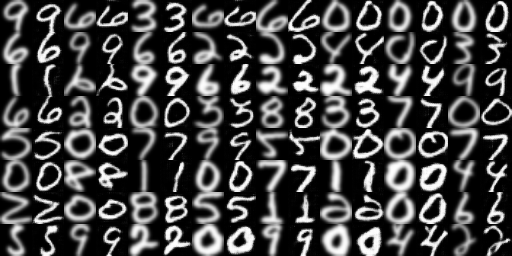

In [0]:
from PIL import Image
image = Image.open('/content/sample-005000-U-M.png')
image

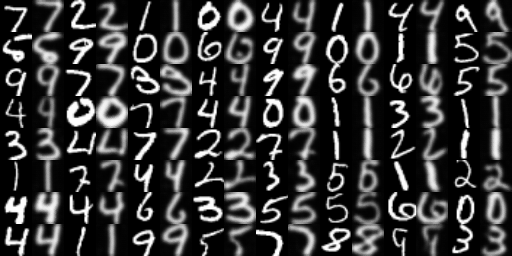

In [0]:
from PIL import Image
image = Image.open('/content/sample-005000-M-U.png')
image

In [0]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=5000, log_step = 100,  use_cycle_consistency_loss=False)

                 G_MtoU                
---------------------------------------
G_MNIST_USPS(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

Iteration [ 1000/ 5000] | d_real_loss: 0.2220 | d_U_loss: 0.0932 | d_M_loss: 0.0504 | d_fake_loss: 0.1436 | g_loss: 0.9194
Saved /content/sample-001000-M-U.png
Saved /content/sample-001000-U-M.png
Iteration [ 1100/ 5000] | d_real_loss: 0.1619 | d_U_loss: 0.2259 | d_M_loss: 0.1988 | d_fake_loss: 0.4247 | g_loss: 0.6991
Iteration [ 1200/ 5000] | d_real_loss: 0.2109 | d_U_loss: 0.0424 | d_M_loss: 0.0451 | d_fake_loss: 0.0874 | g_loss: 1.1110
Iteration [ 1300/ 5000] | d_real_loss: 0.3366 | d_U_loss: 0.0370 | d_M_loss: 0.1136 | d_fake_loss: 0.1505 | g_loss: 0.7218
Iteration [ 1400/ 5000] | d_real_loss: 0.1829 | d_U_loss: 0.1464 | d_M_loss: 0.0465 | d_fake_loss: 0.1930 | g_loss: 1.1514
Iteration [ 1500/ 5000] | d_real_loss: 0.3740 | d_U_loss: 0.0936 | d_M_loss: 0.0359 | d_fake_loss: 0.1295 | g_loss: 0.5534
Iteration [ 1600/ 5000] | d_real_loss: 0.2273 | d_U_loss: 0.1515 | d_M_loss: 0.0726 | d_fake_loss: 0.2241 | g_loss: 0.5994
Iteration [ 1700/ 5000] | d_real_loss: 0.1631 | d_U_loss: 0.3557 

Iteration [ 2000/ 5000] | d_real_loss: 0.1403 | d_U_loss: 0.0380 | d_M_loss: 0.0597 | d_fake_loss: 0.0977 | g_loss: 1.2202
Saved /content/sample-002000-M-U.png
Saved /content/sample-002000-U-M.png
Iteration [ 2100/ 5000] | d_real_loss: 0.3136 | d_U_loss: 0.0427 | d_M_loss: 0.0583 | d_fake_loss: 0.1010 | g_loss: 0.8064
Iteration [ 2200/ 5000] | d_real_loss: 0.0880 | d_U_loss: 0.1548 | d_M_loss: 0.0453 | d_fake_loss: 0.2001 | g_loss: 0.7306
Iteration [ 2300/ 5000] | d_real_loss: 0.2123 | d_U_loss: 0.1884 | d_M_loss: 0.0650 | d_fake_loss: 0.2533 | g_loss: 0.5011
Iteration [ 2400/ 5000] | d_real_loss: 0.2846 | d_U_loss: 0.2948 | d_M_loss: 0.0292 | d_fake_loss: 0.3240 | g_loss: 0.5928
Iteration [ 2500/ 5000] | d_real_loss: 0.1387 | d_U_loss: 0.0471 | d_M_loss: 0.0510 | d_fake_loss: 0.0981 | g_loss: 0.6433
Iteration [ 2600/ 5000] | d_real_loss: 0.0956 | d_U_loss: 0.1729 | d_M_loss: 0.0361 | d_fake_loss: 0.2090 | g_loss: 0.5021
Iteration [ 2700/ 5000] | d_real_loss: 0.0478 | d_U_loss: 0.0654 

Iteration [ 3000/ 5000] | d_real_loss: 0.2272 | d_U_loss: 0.0386 | d_M_loss: 0.0846 | d_fake_loss: 0.1232 | g_loss: 0.7984
Saved /content/sample-003000-M-U.png
Saved /content/sample-003000-U-M.png
Iteration [ 3100/ 5000] | d_real_loss: 0.4039 | d_U_loss: 0.0627 | d_M_loss: 0.0470 | d_fake_loss: 0.1097 | g_loss: 0.6154
Iteration [ 3200/ 5000] | d_real_loss: 0.2297 | d_U_loss: 0.0504 | d_M_loss: 0.0284 | d_fake_loss: 0.0788 | g_loss: 1.0219
Iteration [ 3300/ 5000] | d_real_loss: 0.0638 | d_U_loss: 0.0426 | d_M_loss: 0.0409 | d_fake_loss: 0.0836 | g_loss: 1.0732
Iteration [ 3400/ 5000] | d_real_loss: 0.1972 | d_U_loss: 0.1194 | d_M_loss: 0.0188 | d_fake_loss: 0.1382 | g_loss: 0.5326
Iteration [ 3500/ 5000] | d_real_loss: 0.0953 | d_U_loss: 0.0725 | d_M_loss: 0.0221 | d_fake_loss: 0.0946 | g_loss: 1.0044
Iteration [ 3600/ 5000] | d_real_loss: 0.2176 | d_U_loss: 0.1941 | d_M_loss: 0.0697 | d_fake_loss: 0.2638 | g_loss: 0.6038
Iteration [ 3700/ 5000] | d_real_loss: 0.0930 | d_U_loss: 0.0787 

Iteration [ 4000/ 5000] | d_real_loss: 0.1895 | d_U_loss: 0.0846 | d_M_loss: 0.0301 | d_fake_loss: 0.1146 | g_loss: 0.7748
Saved /content/sample-004000-M-U.png
Saved /content/sample-004000-U-M.png
Iteration [ 4100/ 5000] | d_real_loss: 0.1045 | d_U_loss: 0.0651 | d_M_loss: 0.0607 | d_fake_loss: 0.1257 | g_loss: 1.3450
Iteration [ 4200/ 5000] | d_real_loss: 0.2526 | d_U_loss: 0.0585 | d_M_loss: 0.0194 | d_fake_loss: 0.0779 | g_loss: 1.1409
Iteration [ 4300/ 5000] | d_real_loss: 0.1311 | d_U_loss: 0.1578 | d_M_loss: 0.0387 | d_fake_loss: 0.1965 | g_loss: 0.6865
Iteration [ 4400/ 5000] | d_real_loss: 0.1738 | d_U_loss: 0.0858 | d_M_loss: 0.0291 | d_fake_loss: 0.1149 | g_loss: 0.6862
Iteration [ 4500/ 5000] | d_real_loss: 0.2106 | d_U_loss: 0.0381 | d_M_loss: 0.0548 | d_fake_loss: 0.0930 | g_loss: 0.7724
Iteration [ 4600/ 5000] | d_real_loss: 0.1131 | d_U_loss: 0.0545 | d_M_loss: 0.0470 | d_fake_loss: 0.1015 | g_loss: 1.0520
Iteration [ 4700/ 5000] | d_real_loss: 0.1715 | d_U_loss: 0.0777 

Iteration [ 5000/ 5000] | d_real_loss: 0.0940 | d_U_loss: 0.0284 | d_M_loss: 0.0433 | d_fake_loss: 0.0716 | g_loss: 0.8823
Saved /content/sample-005000-M-U.png
Saved /content/sample-005000-U-M.png


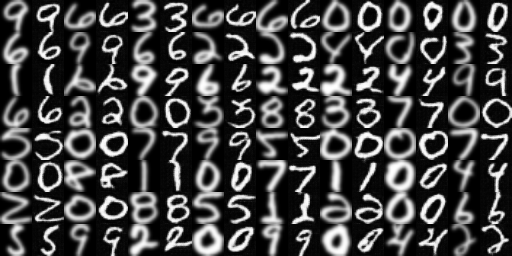

In [0]:
from PIL import Image
image = Image.open('/content/sample-005000-U-M.png')
image

# Testing Wassesrstein Cycle GAN 

What we need to modify : 
1. Turning the Adam optimizer into the RMS Prop optimizer 
2. The discriminator should not end with a sigmoid on the last layer (this is ok) 
3. D_loss =  -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))


G_loss = -torch.mean(D_fake)

4. Clip parameters 

In [0]:
def training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=20000, log_step = 10, batch_size=64, use_cycle_consistency_loss=True):
  # Create generators and discriminators
  G_MtoU, G_UtoM, D_M, D_U = create_model()

  g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())  # Get generator parameters
  d_m_params = list(D_M.parameters())  # Get discriminator parameters
  d_u_params = list(D_U.parameters())  # Get discriminator parameters

  # Create optimizers for the generators and discriminators
  g_optimizer = optim.RMSprop(g_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
  d_m_optimizer = optim.RMSprop(d_m_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
  d_u_optimizer = optim.RMSprop(d_u_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

  iter_M = iter(M_train_loader)
  iter_U = iter(U_train_loader)

  test_iter_M = iter(M_test_loader)
  test_iter_U = iter(U_test_loader)

  fixed_M = to_var(test_iter_M.next()[0])
  fixed_U = to_var(test_iter_U.next()[0])

  iter_per_epoch = min(len(iter_M), len(iter_U))

  for iteration in range(1, train_iters+1):

      # Reset data_iter for each epoch
      if iteration % iter_per_epoch == 0:
          iter_M = iter(M_train_loader)
          iter_U = iter(U_train_loader)

      images_M, labels_M = iter_M.next()
      images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

      images_U, labels_U = iter_U.next()
      images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()

      # ============================================
      #            TRAIN THE DISCRIMINATORS
      # ============================================

      for _ in range(5):
        # Train with real images
        d_m_optimizer.zero_grad()
        d_u_optimizer.zero_grad()

        # Compute the discriminator losses on real images
        out_M = D_M(images_M) # discriminator mnist true
        D_M_loss = - torch.mean(out_M) 

        out_U = D_U(images_U)
        D_U_loss = - torch.mean(out_U)

        d_real_loss = D_M_loss + D_U_loss
        d_real_loss_m = D_M_loss
        d_real_loss_u = D_U_loss
        #d_real_loss.backward()
        #d_optimizer.step()

        # Train with fake images
        #d_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images in domain USPS
        fake_M = G_UtoM(images_U)

        # Compute the loss for D_M
        out_M = D_M(fake_M)
        D_M_loss =  torch.mean(out_M) 

        # 4. Generate fake images that look like domain U based on real images in domain M
        fake_U = G_MtoU(images_M)

        # 5. Compute the loss for D_U
        out_U = D_U(fake_U)
        D_U_loss = torch.mean(out_U) 

        d_fake_loss = D_M_loss + D_U_loss

        d_loss = d_real_loss + d_fake_loss

        d_fake_loss_m = D_M_loss
        d_fake_loss_u = D_U_loss

        d_loss_m = d_real_loss_m + d_fake_loss_m
        d_loss_u = d_real_loss_u + d_fake_loss_u

        d_loss_u.backward()
        d_loss_m.backward()

        d_m_optimizer.step()
        d_u_optimizer.step()

        #d_loss.backward()
        #d_optimizer.step()

        # Clipping discriminator parameters 
        for p in D_M.parameters():
              p.data.clamp_(-0.01, 0.01)
        
        # Clipping discriminator parameters 
        for p in D_U.parameters():
              p.data.clamp_(-0.01, 0.01)

      # =========================================
      #            TRAIN THE GENERATORS
      # =========================================

      ## U--M-->U 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain M based on real images in domain U
      fake_M = G_UtoM(images_U)
      out = D_M(fake_M)

      # 2. Compute the generator loss based on domain M

      g_loss = - torch.mean(out)

      if use_cycle_consistency_loss:
          reconstructed_U = G_MtoU(fake_M)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
          g_loss += cycle_consistency_loss

      #g_loss.backward()
      #g_optimizer.step()

      ## M--U-->M 

      #torch.mean((D_M(G_UtoM(images_U)-1)**2) + torch.mean((images_U - G_MtoU(G_UtoM(images_U)))**2)

      #g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_MtoU(images_M)
      out = D_U(fake_U)

      # 2. Compute the generator loss based on domain U
      #g_loss = - torch.mean(out)
      g_loss += - torch.mean(out)

      if use_cycle_consistency_loss:
          reconstructed_M = G_UtoM(fake_U)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()


      # Print the log info
      if iteration % log_step == 0:
          print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                  D_M_loss.item(), d_fake_loss.item(), g_loss.item()))


      # Save the generated samples
      if iteration % sample_every == 0:
          save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU)

In [0]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=5000, log_step = 100,  use_cycle_consistency_loss=False)

                 G_MtoU                
---------------------------------------
G_MNIST_USPS(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(

Iteration [ 1000/ 5000] | d_real_loss: -0.4124 | d_U_loss: 0.0946 | d_M_loss: 0.0057 | d_fake_loss: 0.1003 | g_loss: 0.4309
Saved /content/sample-001000-M-U.png
Saved /content/sample-001000-U-M.png
Iteration [ 1100/ 5000] | d_real_loss: -0.2091 | d_U_loss: -0.0367 | d_M_loss: -0.1201 | d_fake_loss: -0.1568 | g_loss: 0.2553
Iteration [ 1200/ 5000] | d_real_loss: -0.2281 | d_U_loss: 0.0239 | d_M_loss: -0.1717 | d_fake_loss: -0.1478 | g_loss: 0.2339
Iteration [ 1300/ 5000] | d_real_loss: -0.1451 | d_U_loss: -0.1951 | d_M_loss: -0.0334 | d_fake_loss: -0.2285 | g_loss: 0.2073
Iteration [ 1400/ 5000] | d_real_loss: -0.2063 | d_U_loss: 0.0349 | d_M_loss: -0.1641 | d_fake_loss: -0.1292 | g_loss: 0.2399
Iteration [ 1500/ 5000] | d_real_loss: -0.3129 | d_U_loss: 0.0821 | d_M_loss: -0.1149 | d_fake_loss: -0.0328 | g_loss: 0.2907
Iteration [ 1600/ 5000] | d_real_loss: 0.0523 | d_U_loss: -0.1791 | d_M_loss: -0.1544 | d_fake_loss: -0.3336 | g_loss: 0.1110
Iteration [ 1700/ 5000] | d_real_loss: -0.12

Iteration [ 2000/ 5000] | d_real_loss: -0.1396 | d_U_loss: 0.0277 | d_M_loss: -0.1790 | d_fake_loss: -0.1512 | g_loss: 0.1112
Saved /content/sample-002000-M-U.png
Saved /content/sample-002000-U-M.png
Iteration [ 2100/ 5000] | d_real_loss: -0.1380 | d_U_loss: -0.1176 | d_M_loss: -0.0548 | d_fake_loss: -0.1725 | g_loss: 0.1081
Iteration [ 2200/ 5000] | d_real_loss: -0.2318 | d_U_loss: -0.0026 | d_M_loss: -0.0972 | d_fake_loss: -0.0997 | g_loss: 0.3379
Iteration [ 2300/ 5000] | d_real_loss: -0.1340 | d_U_loss: 0.0013 | d_M_loss: -0.1525 | d_fake_loss: -0.1512 | g_loss: 0.1743
Iteration [ 2400/ 5000] | d_real_loss: -0.1555 | d_U_loss: -0.0638 | d_M_loss: -0.0999 | d_fake_loss: -0.1637 | g_loss: 0.2592
Iteration [ 2500/ 5000] | d_real_loss: -0.1445 | d_U_loss: -0.0671 | d_M_loss: -0.0568 | d_fake_loss: -0.1239 | g_loss: 0.1956
Iteration [ 2600/ 5000] | d_real_loss: 0.0378 | d_U_loss: -0.0925 | d_M_loss: -0.1825 | d_fake_loss: -0.2750 | g_loss: -0.0226
Iteration [ 2700/ 5000] | d_real_loss: 

Iteration [ 3000/ 5000] | d_real_loss: -0.2600 | d_U_loss: -0.0396 | d_M_loss: -0.0292 | d_fake_loss: -0.0689 | g_loss: 0.3601
Saved /content/sample-003000-M-U.png
Saved /content/sample-003000-U-M.png
Iteration [ 3100/ 5000] | d_real_loss: -0.0426 | d_U_loss: -0.0641 | d_M_loss: -0.1778 | d_fake_loss: -0.2419 | g_loss: 0.0277
Iteration [ 3200/ 5000] | d_real_loss: -0.1807 | d_U_loss: -0.0201 | d_M_loss: -0.1142 | d_fake_loss: -0.1343 | g_loss: 0.1791
Iteration [ 3300/ 5000] | d_real_loss: -0.1422 | d_U_loss: -0.0316 | d_M_loss: -0.1097 | d_fake_loss: -0.1413 | g_loss: 0.1719
Iteration [ 3400/ 5000] | d_real_loss: -0.0369 | d_U_loss: -0.0707 | d_M_loss: -0.1775 | d_fake_loss: -0.2481 | g_loss: 0.1117
Iteration [ 3500/ 5000] | d_real_loss: -0.1060 | d_U_loss: -0.0670 | d_M_loss: -0.1047 | d_fake_loss: -0.1717 | g_loss: 0.1026
Iteration [ 3600/ 5000] | d_real_loss: -0.1886 | d_U_loss: -0.0098 | d_M_loss: -0.0858 | d_fake_loss: -0.0956 | g_loss: 0.3044
Iteration [ 3700/ 5000] | d_real_loss

Iteration [ 4000/ 5000] | d_real_loss: -0.0839 | d_U_loss: -0.0807 | d_M_loss: -0.0916 | d_fake_loss: -0.1724 | g_loss: 0.1768
Saved /content/sample-004000-M-U.png
Saved /content/sample-004000-U-M.png
Iteration [ 4100/ 5000] | d_real_loss: -0.0674 | d_U_loss: -0.0949 | d_M_loss: -0.1036 | d_fake_loss: -0.1984 | g_loss: 0.1196
Iteration [ 4200/ 5000] | d_real_loss: -0.1708 | d_U_loss: -0.0734 | d_M_loss: -0.0720 | d_fake_loss: -0.1454 | g_loss: 0.2532
Iteration [ 4300/ 5000] | d_real_loss: -0.1243 | d_U_loss: -0.0564 | d_M_loss: -0.0980 | d_fake_loss: -0.1544 | g_loss: 0.1408
Iteration [ 4400/ 5000] | d_real_loss: -0.0253 | d_U_loss: -0.0537 | d_M_loss: -0.1777 | d_fake_loss: -0.2314 | g_loss: 0.0139
Iteration [ 4500/ 5000] | d_real_loss: -0.0564 | d_U_loss: -0.0747 | d_M_loss: -0.1809 | d_fake_loss: -0.2556 | g_loss: 0.1583
Iteration [ 4600/ 5000] | d_real_loss: -0.1041 | d_U_loss: 0.0367 | d_M_loss: -0.1837 | d_fake_loss: -0.1471 | g_loss: 0.0160
Iteration [ 4700/ 5000] | d_real_loss:

Iteration [ 5000/ 5000] | d_real_loss: -0.0702 | d_U_loss: -0.0936 | d_M_loss: -0.1226 | d_fake_loss: -0.2162 | g_loss: 0.1375
Saved /content/sample-005000-M-U.png
Saved /content/sample-005000-U-M.png
